# Determining drivers of sales in the Rossmanstore

In [ ]:
 # Importing Libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
from sklearn.model_selection import train_test_split

import scipy as sc
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn import preprocessing
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
import keras 
import tensorflow


from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report


from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

import time


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
rosstrain_df = pd.read_csv("/content/drive/MyDrive/ML Learning csv/rossman_train.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
rossstore_df = pd.read_csv("/content/drive/MyDrive/ML Learning csv/rossman_store.csv")

In [ ]:
rosstest_df = pd.read_csv("/content/drive/MyDrive/ML Learning csv/rossman_test.csv")

In [ ]:
rosstrain_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


###Data cleaning and exploration

Selecting model params

In [ ]:
rosstrain_df.isna().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [ ]:
rossstore_df.isna().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

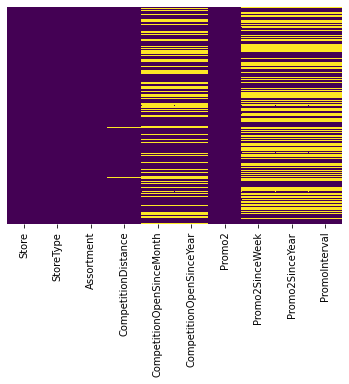

In [ ]:
sns.heatmap(rossstore_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [ ]:
#propotion of missing values
null_count = rossstore_df.isnull().sum()
null_percentage = round((rossstore_df.isnull().sum()/rossstore_df.shape[0])*100, 2)
null_df = pd.DataFrame({'column_name' : rossstore_df.columns,'null_count' : null_count,'null_percentage': null_percentage})
null_df.reset_index(drop = True, inplace = True)
null_df.sort_values(by = 'null_percentage', ascending = False)

,column_name,null_count,null_percentage
7,Promo2SinceWeek,544,48.79
8,Promo2SinceYear,544,48.79
9,PromoInterval,544,48.79
4,CompetitionOpenSinceMonth,354,31.75
5,CompetitionOpenSinceYear,354,31.75
3,CompetitionDistance,3,0.27
0,Store,0,0.00
1,StoreType,0,0.00
2,Assortment,0,0.00
6,Promo2,0,0.00


In [ ]:
rossstore_df.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


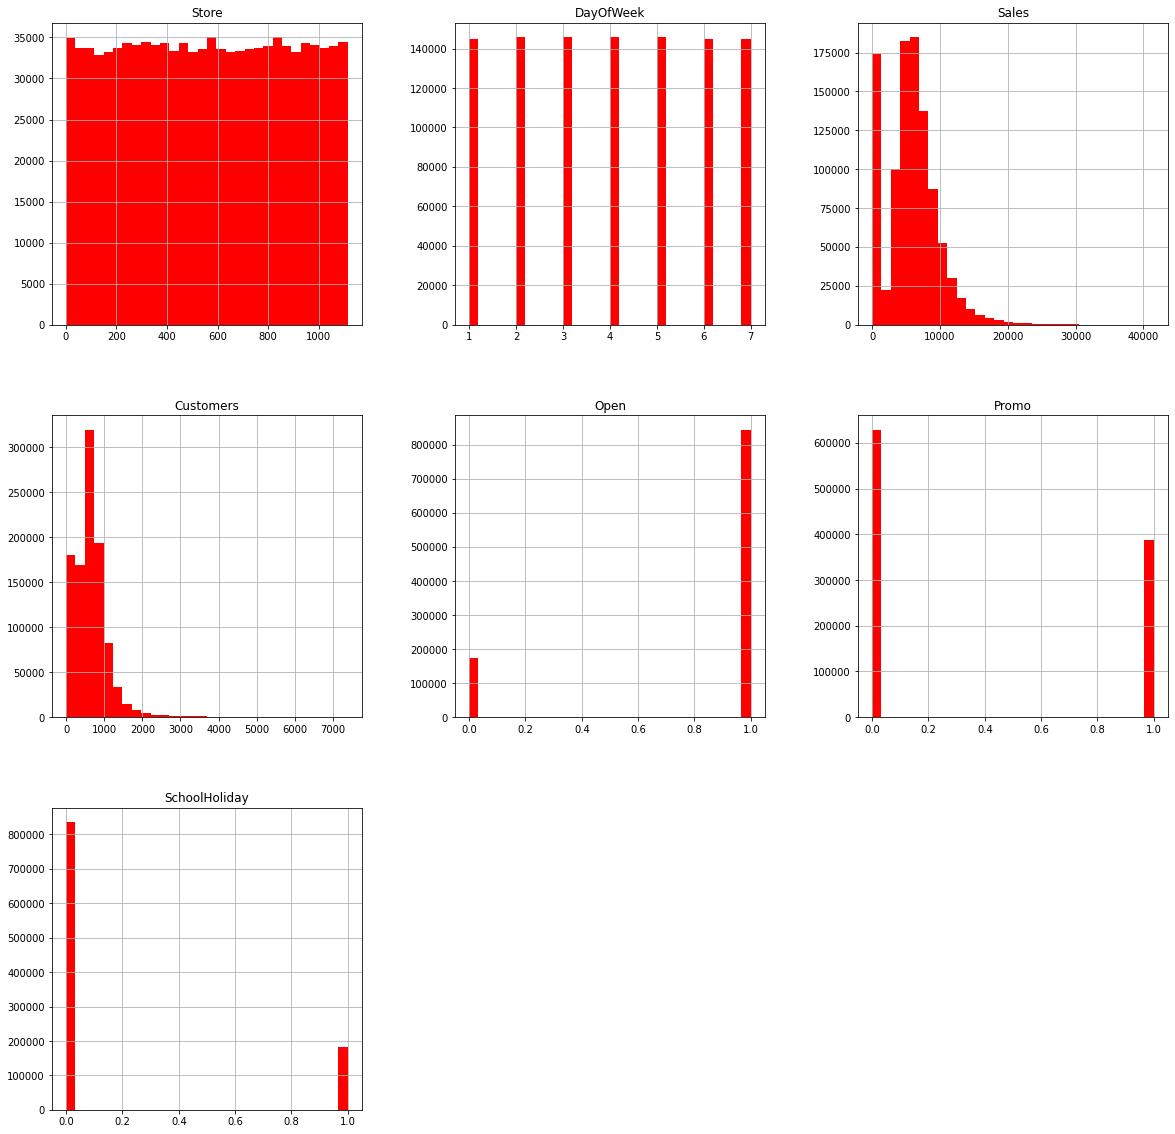

In [ ]:
rosstrain_df.hist(bins = 30, figsize = (20, 20), color = 'r');

In [ ]:
# Number of transactions per day in closed/open stores
closed_train_df = rosstrain_df[rosstrain_df['Open'] == 0]
open_train_df = rosstrain_df[rosstrain_df['Open'] == 1]
print('Total = ', len(rosstrain_df))
print('number of stores/day closed = ', len(closed_train_df))
print('number of stores/day open = ', len(open_train_df))

Total =  1017209
number of stores/day closed =  172817
number of stores/day open =  844392


In [ ]:
#closed_train_df.head()

In [ ]:
#open_train_df.head()

In [ ]:
rossstore_df[rossstore_df['CompetitionOpenSinceMonth'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1130.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,540.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [ ]:
#store_new = rossstore_df.copy()
#avg_comp_dist = store_new['CompetitionDistance'].mean()
#store_new['CompetitionDistance'] = store_new['CompetitionDistance'].fillna(avg_comp_dist)

# Create a new unknown category for missing values in categorical columns
#store_new['CompetitionOpenSinceMonth'] = store_new['CompetitionOpenSinceMonth'].fillna('mean')
#store_new['CompetitionOpenSinceYear'] = store_new['CompetitionOpenSinceYear'].fillna('mean')
#store_new['PromoInterval'] = store_new['PromoInterval'].fillna('mean')
#store_new['Promo2SinceYear'] = store_new['Promo2SinceYear'].fillna('mean')
#store_new['Promo2SinceWeek'] = store_new['Promo2SinceWeek'].fillna('mean')



In [ ]:
CompetitionOpenSinceMonth_mean = rossstore_df['CompetitionOpenSinceMonth'].mean()
CompetitionOpenSinceMonth_mean
rossstore_df['CompetitionOpenSinceMonth'].fillna(CompetitionOpenSinceMonth_mean,inplace=True)

In [ ]:
CompetitionOpenSinceYear_mean = rossstore_df['CompetitionOpenSinceYear'].mean()
CompetitionOpenSinceYear_mean
rossstore_df['CompetitionOpenSinceYear'].fillna(CompetitionOpenSinceYear_mean,inplace=True)

In [ ]:
Promo2SinceYear_mean = rossstore_df['Promo2SinceYear'].mean()
Promo2SinceYear_mean
rossstore_df['Promo2SinceYear'].fillna(Promo2SinceYear_mean,inplace=True)

In [ ]:
Promo2SinceWeek_mean = rossstore_df['Promo2SinceWeek'].mean()
Promo2SinceWeek_mean
rossstore_df['Promo2SinceWeek'].fillna(Promo2SinceWeek_mean,inplace=True)

In [ ]:
CompetitionDistance_mean = rossstore_df['CompetitionDistance'].mean()
CompetitionDistance_mean
rossstore_df['CompetitionDistance'].fillna(CompetitionDistance_mean,inplace=True)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
le = LabelEncoder()

In [ ]:
rossstore_df.PromoInterval = le.fit_transform(rossstore_df.PromoInterval)

In [ ]:
rossstore_df.StoreType = le.fit_transform(rossstore_df.StoreType)

In [ ]:
rossstore_df.Assortment = le.fit_transform(rossstore_df.Assortment)

In [ ]:
rossstore_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,2,0,1270.0,9.0,2008.0,0,23.595447,2011.763573,3
1,2,0,0,570.0,11.0,2007.0,1,13.000000,2010.000000,1
2,3,0,0,14130.0,12.0,2006.0,1,14.000000,2011.000000,1
3,4,2,2,620.0,9.0,2009.0,0,23.595447,2011.763573,3
4,5,0,0,29910.0,4.0,2015.0,0,23.595447,2011.763573,3


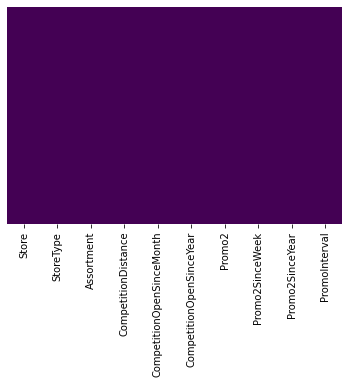

In [ ]:
sns.heatmap(rossstore_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [ ]:
sales_train_all_df = pd.merge(rosstrain_df, rossstore_df, how = 'inner', on = 'Store')

In [ ]:
sales_train_all_df.shape

(1017209, 18)

In [ ]:
sales_train_all_df.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1017204,1115,6,2013-01-05,4771,339,1,0,0,1,3,2,5350.0,7.224704,2008.668857,1,22.0,2012.0,2
1017205,1115,5,2013-01-04,4540,326,1,0,0,1,3,2,5350.0,7.224704,2008.668857,1,22.0,2012.0,2
1017206,1115,4,2013-01-03,4297,300,1,0,0,1,3,2,5350.0,7.224704,2008.668857,1,22.0,2012.0,2
1017207,1115,3,2013-01-02,3697,305,1,0,0,1,3,2,5350.0,7.224704,2008.668857,1,22.0,2012.0,2
1017208,1115,2,2013-01-01,0,0,0,0,a,1,3,2,5350.0,7.224704,2008.668857,1,22.0,2012.0,2


In [ ]:
sales_train_all_df=sales_train_all_df.replace(to_replace="a",value="1")
sales_train_all_df=sales_train_all_df.replace(to_replace="b",value="1")
sales_train_all_df=sales_train_all_df.replace(to_replace="c",value="1")

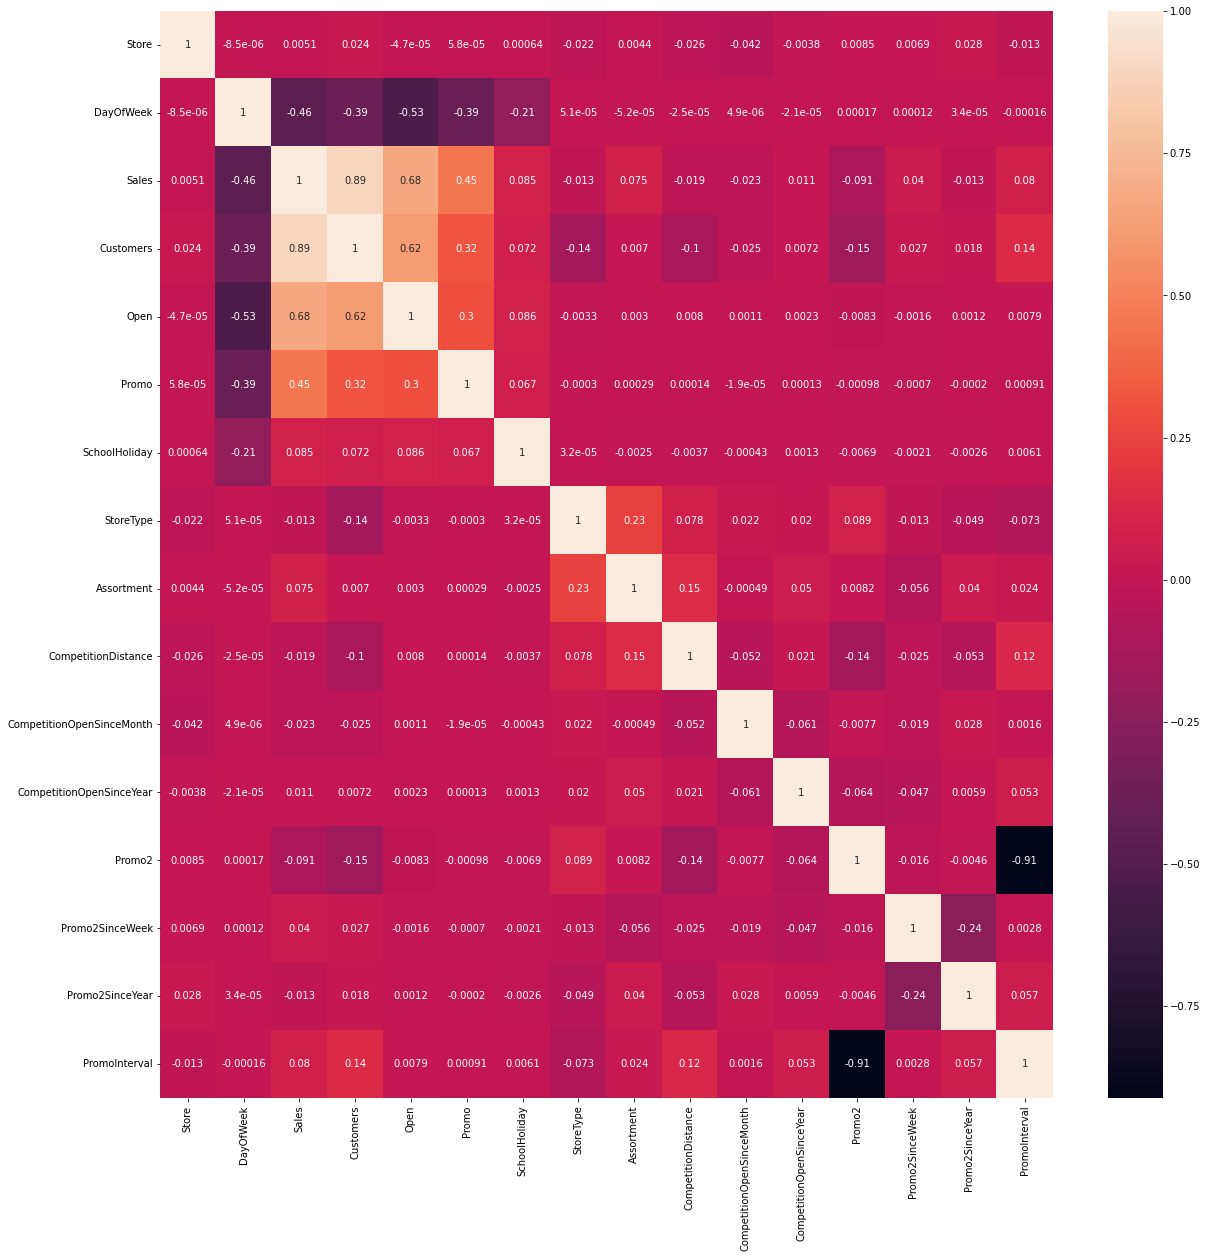

In [ ]:
correlations = sales_train_all_df.corr()
f, ax = plt.subplots(figsize = (20, 20))
sns.heatmap(correlations, annot = True);

In [ ]:
X = sales_train_all_df.drop(['Sales','Date'], axis=1) #.select_dtypes(['number'])
Y = sales_train_all_df['Sales']

In [ ]:
#X.head()

In [ ]:
Y.head()

0    5263
1    5020
2    4782
3    5011
4    6102
Name: Sales, dtype: int64

In [ ]:
X.shape,Y.shape

((1017209, 16), (1017209,))

###Model building

In [ ]:
X_train,X_test, Y_train,Y_test= train_test_split(X,Y,test_size=0.2)

In [ ]:
X_train.shape,Y_train.shape

((813767, 16), (813767,))

In [ ]:
X_test.shape,Y_test.shape

((203442, 16), (203442,))

In [ ]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_log_error,r2_score

In [ ]:
model=linear_model.LinearRegression()

In [ ]:
X_train.head()

,Store,DayOfWeek,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
719541,790,2,919,1,1,0,0,3,2,9070.0,12.000000,2003.000000,0,23.595447,2011.763573,3
78709,87,7,0,0,0,0,0,0,0,560.0,12.000000,2010.000000,0,23.595447,2011.763573,3
469841,515,4,579,1,0,0,0,3,2,11260.0,7.224704,2008.668857,1,9.000000,2011.000000,0
924168,1014,2,1440,1,1,0,0,0,2,210.0,7.224704,2008.668857,1,31.000000,2013.000000,1
910350,998,2,575,1,0,0,1,0,0,780.0,9.000000,2005.000000,1,5.000000,2013.000000,0


In [ ]:
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf

In [ ]:
model.fit(X_train,Y_train)

LinearRegression()

In [ ]:
X_test.head()

,Store,DayOfWeek,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
269299,297,1,689,1,0,0,0,0,0,2300.0,9.000000,2010.000000,0,23.595447,2011.763573,3
173367,192,5,595,1,1,0,0,3,2,2770.0,3.000000,2008.000000,1,40.000000,2014.000000,1
862047,946,2,641,1,1,0,1,0,0,2220.0,12.000000,2011.000000,1,14.000000,2015.000000,1
286980,316,4,950,1,1,0,0,3,0,9000.0,8.000000,2001.000000,0,23.595447,2011.763573,3
637915,700,2,0,0,0,0,0,0,2,830.0,7.224704,2008.668857,1,27.000000,2013.000000,1


In [ ]:
Y_pred=model.predict(X_test)

In [ ]:
print ('Coefficients:',model.coef_)
print( 'Intercept:',model. intercept_)
print('Mean squared error (MSE): %.2f'
 %mean_squared_error (Y_test, Y_pred))
print ('Coefficient of determination (R^2): %.2f'
% r2_score(Y_test, Y_pred))

Coefficients: [-1.28635730e-01 -7.45664792e+01  6.31840164e+00  1.31106351e+03
  1.24729850e+03 -7.67627864e+02  6.27729650e+01  2.19852407e+02
  1.79469619e+02  2.39588185e-02 -4.63810369e+00  1.42627005e+00
  3.53914049e+01  8.26682331e+00 -5.07929076e+01 -7.62645430e+01]
Intercept: 99318.78140479143
Mean squared error (MSE): 1984784.98
Coefficient of determination (R^2): 0.87


In [ ]:
r2_score(Y_test,Y_pred)

0.8664508673614774

Regression equation

99318.78140479143 - 0.1286357*Store  - 74.566479*DayOfWeek + 6.31840164*Customers + 1311.06351*Open + 1247.29850*Promo - 767.627864*StateHoliday + 62.7729650*SchoolHoliday + 219.852407*StoreType + 179.469619*Assortment + 0.023958818*CompetitionDistance -4.63810369*CompetitionOpenSinceMonth + 1.42627005*CompetitionOpenSinceYear + 35.3914049*Promo2 + 8.26682331*Promo2SinceWeek - 50.7929076*Promo2SinceYear - 76.2645430 *PromoInterval italicized text

Based on the data the biggest drivers of sales are the following variables:

*   Open

*   Promo

*   Day of the week of sales

*   Store type

*   Assortment

In [ ]:
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from scipy import stats
from statsmodels.compat import lzip

# Determining how promotions affect sales in different stores

Second regression model

In [ ]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
X1 = sales_train_all_df[[ "Sales","Promo","Promo2","StoreType"]]
y1 = sales_train_all_df["Sales"]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    X1, y1, test_size=0.30, random_state=42)

In [ ]:
x_train[[ "Sales","Promo","StoreType","Promo2"]]

,Sales,Promo,StoreType,Promo2
817013,3513,1,2,1
861474,3858,0,0,1
772779,6230,0,0,1
81436,7884,0,0,0
862893,0,0,0,1
...,...,...,...,...
259178,3655,0,0,0
365838,7779,1,0,1
131932,5349,0,3,1
671155,7079,1,0,1


In [ ]:
import patsy

In [ ]:
model3 = smf.ols("Sales ~ Promo + Promo2 + C(StoreType):Promo + C(StoreType):Promo2", data=x_train).fit()

In [ ]:
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                 2.485e+04
Date:                Fri, 23 Sep 2022   Prob (F-statistic):               0.00
Time:                        23:14:39   Log-Likelihood:            -6.8016e+06
No. Observations:              712046   AIC:                         1.360e+07
Df Residuals:                  712037   BIC:                         1.360e+07
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

The Final Model and Interpretation of the Results 

*   Promo (3643.4732):
Promo is more effective than Promo2 as we do see a for a 1 unit increase in promo increases sales by 3643.4732; a one unit increase in promo2 reduces sales by 664.1116 

*   Promo2 (-664.1116):
Promo2 negatively impacts sales; if stores increase their budget on Promo2, sales will decrease 

*   Promo:StoreType B (2486.4432):      
1 unit increase in promo increases sales of store B by 2486.4432  

*  Promo:StoreType C (-71.0052):
1 unit increase in promo reduces sales of store C by 71.0052

*   Promo:StoreType D (-204.676):
1 unit increase in promo reduces sales of store C by 204.676 
Promo negatively affects sales for store type D

*   Promo2:StoreType B (1465.0362):
1 unit increase in promo increases sales of store B by 1465.0362

*   Promo2:StoreType C (-343.8481):
1 unit increase in promo2 reduces sales of store C by 343.8481
Promo2 negatively affects sales for store type C

*   Promo2:StoreType D (61.2979):
1 unit increase in promo reduces sales of store C by 61.2979








 







 

 

   


 



